In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import string
import nltk
import logic.processing as lp
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Flotchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Flotchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Flotchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Flotchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
path = os.getcwd()

In [5]:
rpath_train = os.path.join(os.path.dirname(path),'raw_data', 'drugsComTrain_raw.csv') 

In [6]:
df_train = pd.read_csv(rpath_train)

In [7]:
df_train.shape

(161297, 7)

In [8]:
rpath_test = os.path.join(os.path.dirname(path),'raw_data', 'drugsComTest_raw.csv') 

In [9]:
df_test = pd.read_csv(rpath_test)

In [10]:
df_test.shape

(53766, 7)

In [11]:
def data_filter(df,top_conditions=10,uselfCount=0,min_length=30):
    
    df = df.dropna()
    condition_distribution = df['condition'].value_counts()
    top_conditions = condition_distribution.head(top_conditions)
    top_conditions_list = top_conditions.index.tolist()
    df = df[df['condition'].isin(top_conditions_list)]
    df = df[df['usefulCount']>uselfCount]
    df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
    df = df[df.review_length>=min_length]
    
    return df
    

In [12]:
def process(df):
    def clean(st):
        for punc in string.punctuation:
            st = st.replace(punc, '')
        ans = st.casefold().replace('\n', ' ')
        ansd = ''.join(x for x in ans if not x.isdigit())
        stop = set(stopwords.words('english'))
        tokens = word_tokenize(ansd)
        ansdd = [y for y in tokens if y not in stop]
        lemmaverb = [WordNetLemmatizer().lemmatize(word, pos='v') for word in ansdd]
        lemmanouns = [WordNetLemmatizer().lemmatize(word, pos='n') for word in lemmaverb]
        nans = ' '.join(lemmanouns)
        return nans
    df['review clean'] = df.review.apply(clean)
    return df

In [13]:
df_filter_train = data_filter(df_train)
df_filter_test = data_filter(df_test)

In [37]:
df_filter_train.shape

(63888, 9)

In [14]:
df_proc_train = process(df_filter_train)

In [15]:
df_proc_test = process(df_filter_test)

In [16]:
X_train = df_proc_train['review clean']
y_train = df_proc_train['condition']

In [17]:
X_test = df_proc_test['review clean']
y_test = df_proc_test['condition']

In [18]:
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
    ('oversample', RandomOverSampler(random_state=42)),
    ('nb', MultinomialNB(alpha=0.1))
])
pipeline

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
                ('oversample', RandomOverSampler(random_state=42)),
                ('nb', MultinomialNB(alpha=0.1))])

In [19]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
                ('oversample', RandomOverSampler(random_state=42)),
                ('nb', MultinomialNB(alpha=0.1))])

In [20]:
y_pred = pipeline.predict(X_test)

In [21]:
cm = confusion_matrix(y_test, y_pred)

<Figure size 1000x800 with 0 Axes>

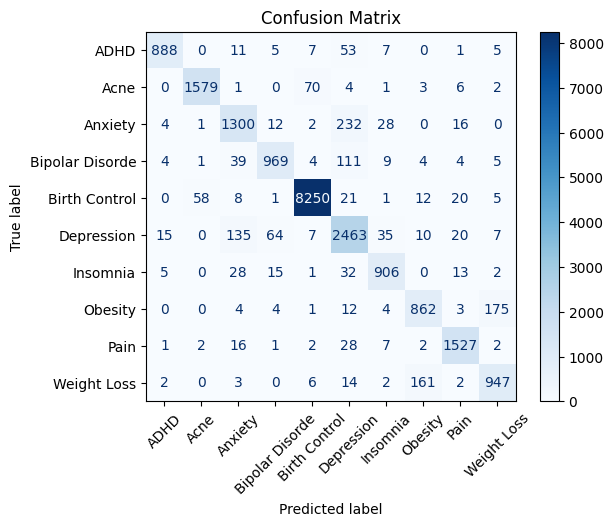

In [22]:
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
cm_display.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           ADHD       0.97      0.91      0.94       977
           Acne       0.96      0.95      0.95      1666
        Anxiety       0.84      0.82      0.83      1595
Bipolar Disorde       0.90      0.84      0.87      1150
  Birth Control       0.99      0.98      0.99      8376
     Depression       0.83      0.89      0.86      2756
       Insomnia       0.91      0.90      0.91      1002
        Obesity       0.82      0.81      0.81      1065
           Pain       0.95      0.96      0.95      1588
    Weight Loss       0.82      0.83      0.83      1137

       accuracy                           0.92     21312
      macro avg       0.90      0.89      0.89     21312
   weighted avg       0.92      0.92      0.92     21312



Let's try it out!

In [32]:
my_symptoms = ["being unable to sit still, especially in calm or quiet surroundings."]

In [33]:
prediction = pipeline.predict(my_symptoms)
prediction[0]

'ADHD'

In [35]:
prediction_prob = pipeline.predict_proba(my_symptoms)
prediction_prob

array([[0.59683475, 0.00095103, 0.17177559, 0.12947483, 0.00097147,
        0.05337663, 0.02264324, 0.01367156, 0.00710645, 0.00319447]])

In [36]:
labels = pipeline.named_steps['nb'].classes_

print("Probabilities for the new text:")
for label, prob in zip(labels, prediction_prob[0]):
    print(f"  {label}: {prob:.4f}")

Probabilities for the new text:
  ADHD: 0.5968
  Acne: 0.0010
  Anxiety: 0.1718
  Bipolar Disorde: 0.1295
  Birth Control: 0.0010
  Depression: 0.0534
  Insomnia: 0.0226
  Obesity: 0.0137
  Pain: 0.0071
  Weight Loss: 0.0032
